<div style="background-color: #ccffcc; padding: 10px;"> 
    <h1> Physics-Informed Neural Networks Part 3</h1>
    <h2> Navier-Stokes PINNs Example </h2>
</div>   

# Overview

This notebook is based on two papers: *[Physics-Informed Neural Networks: A Deep Learning Framework for Solving Forward and Inverse Problems Involving Nonlinear Partial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125)* and *[Hidden Physics Models: Machine Learning of Nonlinear Partial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999117309014)* with the help of  Fergus Shone and Michael Macraild.

These tutorials will go through solving Partial Differential Equations using Physics-Informed Neural Networks, focusing on the Burgers Equation and a more complex example using the Navier Stokes Equation.

**This introduction section is replicated in all PINN tutorial notebooks (please skip if you've already been through).** 


    

</div>

<div style="background-color: #ccffcc; padding: 10px;">

<h1>Physics-Informed Neural Networks</h1>

For a typical neural network using algorithms like gradient descent to look for a hypothesis, the data are the only guide. However, if the data are noisy or sparse, and we already have governing physical models, we can use the knowledge we already have to optimise and inform the algorithms. This can be done via [feature engineering](https://www.ibm.com/think/topics/feature-engineering) or by adding a physical inconsistency term to the loss function.


<a href="https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414">
<img src="https://miro.medium.com/max/700/1*uM2Qh4PFQLWLLI_KHbgaVw.png">
</a>   
 
 
## The very basics

If you are new to neural networks, there is a [toy neural network Python code example](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/tree/main/ToyNeuralNetwork) included in the [LIFD ENV ML Notebooks Repository](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS). There we cover some of the fundamentals of neural nets and show how to build a multi-layer neural network from scratch.

    
## Recommended reading
    
The in-depth theory behind neural networks will not be covered here as this tutorial focuses on the application of machine-learning methods. If you wish to learn more, here are some great starting points:
 


* [Introduction to neural networks](https://victorzhou.com/blog/intro-to-neural-networks/)
* [Maziar Rassi's Physics-Informed Neural Networks GitHub page](https://maziarraissi.github.io/PINNs/)

</div>


<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Machine Learning Theory </h1>
<a href="https://victorzhou.com/series/neural-networks-from-scratch/">
<img src="https://victorzhou.com/media/nn-series/network.svg">
</a>

    
## Physics-Informed Neural Networks

Neural networks work by using lots of data to tune weights and biases, thereby minimising the loss function and enabling them to act as universal function approximators. However, these purely data-driven models lose their robustness when data is limited. By using known physical laws or empirically validated relationships, the solutions from neural networks can be sufficiently constrained by disregarding unrealistic solutions.
    
A Physics-Informed Neural Network considers a parameterised and non-linear partial differential equation in the general form:



    
\begin{align}
     u_t + \mathcal{N}[u; \lambda] &= 0, && x \in \Omega, t \in [0,T],\\
\end{align}
    


where $\mathcal{u(t,x)}$ denotes the latent solution, $\mathcal{N}$ is a non-linear differential operator acting on $u$, $\mathcal{\lambda}$ and $\Omega$ is a subset of $\mathbb{R}^D$ (the prescribed domain). This setup encapsulates a wide range of problems, such as diffusion processes, conservation laws,  advection-diffusion-reaction  systems,  and  kinetic  equations.

Here we will apply this methodology for the Navier stokes equations.


</div>    

<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

## PyTorch
    
There are many machine-learning libraries available for Python. [PyTorch](https://pytorch.org/) a is one such library. If you have a GPU on the machine you are using, PyTorch should automatically use it and run the code in the notebooks even faster! This will work automatically with google Colab. If using your own machine, please ensure that the GPU-enabled version of PyTorch is installed.


## Further Reading

* [Running Jupyter Notebooks](https://jupyter.readthedocs.io/en/latest/running.html#running)
* [PyTorch optimisers](https://nbviewer.org/github/bentrevett/a-tour-of-pytorch-optimizers/blob/main/a-tour-of-pytorch-optimizers.ipynb)


</div>
    
<hr>

<div style="background-color:  #f4b85d; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied.

<h2> Python Packages: </h2>

* Python 3
* PyTorch
* NumPy 
* Matplotlib
* SciPy

    
</div>


**Contents:**

1. 1D Heat Equation non-ML Example
2. 1D Heat Equation PINN Example
    * 1D Heat Equation Forwards
    * 1D Heat Equation Inverse
3. **Navier-Stokes PINNs Discovery of PDEs**

<hr>
<div style="background-color: #ccffcc; padding: 10px;">

<h1> Navier-Stokes inverse data-driven discovery of PDEs </h1>

Navier-Stokes equations describe the physics of many phenomena of scientific and engineering interest. They may be used to model the weather, ocean currents, water flow in a pipe and air flow around a wing. The Navier-Stokes equations in their full and simplified forms help with the design of aircraft and cars, the study of blood flow, the design of power stations, the analysis of the dispersion of pollutants, and many other applications. Let us consider the Navier-Stokes equations in two dimensions (2D) given explicitly by

\begin{eqnarray}    
u_t + \lambda_1 (u u_x + v u_y) = -p_x + \lambda_2(u_{xx} + u_{yy}),\\
v_t + \lambda_1 (u v_x + v v_y) = -p_y + \lambda_2(v_{xx} + v_{yy}),
\end{eqnarray}
   
where $u(t, x, y)$ denotes the $x$-component of the velocity field, $v(t, x, y)$ the $y$-component, and $p(t, x, y)$ the pressure. Here, $\lambda = (\lambda_1, \lambda_2)$ are the unknown parameters. We seek divergence-free solutions for which
\begin{equation} 
u_x + v_y = 0,
\end{equation}
       
which we implement by finding a stream function $\psi(t,x,y)$ such that

\begin{equation}    
u = \psi_y,\ \ \ v = -\psi_x.
\end{equation}

Given noisy measurements

\begin{equation}
\{t^i, x^i, y^i, u^i, v^i\}_{i=1}^{N}
\end{equation}
    
of the velocity field, we are interested in learning the parameters $\lambda$ as well as the pressure $p(t,x,y)$. We define $f(t,x,y)$ and $g(t,x,y)$ to be given by

\begin{equation}
\begin{array}{c}
f := u_t + \lambda_1 (u u_x + v u_y) + p_x - \lambda_2(u_{xx} + u_{yy}),\\
g := v_t + \lambda_1 (u v_x + v v_y) + p_y - \lambda_2(v_{xx} + v_{yy}),
\end{array}
\end{equation}

and proceed by jointly approximating $\psi(t,x,y)$ and $p(t,x,y)$ using a single neural network with two outputs. The network is constrained by 
1. Data
2. Navier Stokes equations with unknown $(\lambda_1, \lambda_2)$, for which we minimise $f(t,x,y)$ and $g(t,x,y)$.

Overall, the network is trained by minimizing the mean squared error loss

\begin{equation}
\begin{array}{rl}
MSE :=& \frac{1}{N_{data}} \sum_{i=1}^{N_{data}} \left(|u(t^i,x^i,y^i) - u^i|^2 + |v(t^i,x^i,y^i) - v^i|^2\right) \\
    +& \frac{1}{N_{phys}}\sum_{i=1}^{N_{phys}} \left(|f(t^i,x^i,y^i)|^2 + |g(t^i,x^i,y^i)|^2\right).
\end{array}
\end{equation}

</div>

<div style="background-color: #cce5ff; padding: 10px;">
Load in all required modules (including some auxillary code) and turn off warnings. 
</div>

In [29]:
# For readability: disable warnings
import warnings
import os
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
import matplotlib.pyplot as plt
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import scipy.sparse as sp
import scipy.sparse.linalg as la
from pyDOE import lhs
import requests

<div style="background-color: #ccffcc; padding: 10px;">

# 1. Noiseless Data Preparation

We read in a model of 2D incompressible flow past a circular cylinder, computed using the Navier Stokes equations discretised with a spectral/hp-element method at high resolution. The solution is evolved to a periodic steady state, and is considered the "truth" to which our PINN model will be compared. The true underlying parameters are $(\lambda_1, \lambda_2) = (1, 0.01)$. Details of the forward calculation can be found here: [physics-informed neural network](https://arxiv.org/abs/1711.10566) 

We downsample this original data to a relatively small number of measurements, which is then used for training our PINN. Not only do we try to find the parameters of the neural network, but simultaneously we attempt to discover the parameters $(\lambda_1, \lambda_2)$.


- **Input Data**: Prepare the input data by downsampling and organizing it into training sets.
  - `x_train`, `y_train`, `t_train`: Input features (spatial and temporal coordinates).
  - `u_train`, `v_train`: Target outputs (velocity components).

In [30]:
# Load and reformat the data. 
data = scipy.io.loadmat('Data/cylinder_nektar_wake.mat')

U_star = data['U_star'] # velocity coordinates (N x 2 x T)
P_star = data['p_star'] # pressure coordinates  (N x T)
t_star = data['t'] # temporal coordinates  (T x 1)
X_star = data['X_star'] # Spatial coordinates (N x 2)

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

## Downsample the data to leave N_train randomly distributed points
## 
N_train = 5000 # number of data points
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]


<div style="background-color: #ccffcc; padding: 10px;">

This code defines a neural network with Xavier initialization in PyTorch. Xavier initialization is designed to keep the scale of the gradients roughly the same in all layers.

`NeuralNet()` constructs the network U(X) where X is a matrix containing the input and output coordinates, i.e. x,t, and X is normalised so that all values lie between -1 and 1 (this improves training). The tanh activation function is applied to each layer in the sequence, except for the last layer.

In [31]:
# Xavier Initialization for PyTorch
def xavier_init(size):
    """
    Initialize the weights of a layer using Xavier initialization.

    Parameters:
    size (tuple): A tuple containing the dimensions of the layer (in_dim, out_dim).

    Returns:
    torch.Tensor: A tensor with the initialized weights.
    """
    in_dim, out_dim = size
    xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
    return torch.randn(in_dim, out_dim) * xavier_stddev

# Neural Network Initialization
class NeuralNet(nn.Module):
    """
    A simple feedforward neural network with tanh activation functions.

    Attributes:
    layers (nn.ModuleList): A list of linear layers.
    lb (torch.Tensor): Lower bound for input normalization.
    ub (torch.Tensor): Upper bound for input normalization.
    """
    def __init__(self, layers):
        """
        Initialize the neural network.

        Parameters:
        layers (list): A list containing the number of neurons in each layer.
        """
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.lb = None
        self.ub = None

    def forward(self, X):
        """
        Forward pass through the network.

        Parameters:
        X (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The output of the network.
        """
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(len(self.layers) - 1):
            H = torch.tanh(self.layers[l](H))
        return self.layers[-1](H)

<hr>

<div style="background-color: #ccffcc; padding: 10px;">

This code defines a Physics-Informed Neural Network (PINN) model for solving the Navier-Stokes equations. Below are the key components:

#### PINN Class
- **Class Name:** `PINN`
- **Purpose:** Defines a PINN model to predict fluid dynamics using the Navier-Stokes equations.
- **Attributes:**
  - `model` (NeuralNet): Neural network model for the PINN.
  - `x`, `y`, `t` (torch.Tensor): Input coordinates and time as PyTorch tensors.
  - `u`, `v` (torch.Tensor): Velocity components as PyTorch tensors.
  - `lambda_1`, `lambda_2` (torch.Tensor): Learnable parameters for the Navier-Stokes equations.
  - `optimizer` (torch.optim.Adam): Optimizer for training the model.
- **Methods:**
  - `__init__(self, x, y, t, u, v, layers)`: Initializes the PINN model with input data and network layers.
  - `predict(self, x_star, y_star, t_star)`: Predicts the velocity components and pressure at given coordinates and time.
  - `compute_loss(self)`: Computes the loss function for training the model.
  - `net_NS(self)`: Defines the Navier-Stokes equation model and computes necessary gradients.
  - `train(self, nIter)`: Trains the model for a specified number of iterations.

</div>


<div style="background-color: #cce5ff; padding: 10px;">

### Autograd in PyTorch

This is a more complex model than our 1D heat equation so we need to consider our computation of gradients a bit more carefully. Autograd is PyTorch's automatic differentiation engine that powers neural network training. It provides automatic computation of gradients for tensor operations, which is essential for backpropagation.

- PyTorch records operations on tensors that have `requires_grad=True` to create a computation graph.
- When `.backward()` is called on a tensor, PyTorch traverses this graph to compute gradients for all tensors involved in the computation.

- **Computation Graph**:
  - The computation graph is a directed acyclic graph where nodes represent operations and edges represent tensors.
  - By default, PyTorch frees the computation graph after the backward pass to save memory.

- **`retain_graph=True`**:
  - By default, PyTorch frees the computation graph after the backward pass. If you need to perform multiple backward passes on the same graph (e.g., higher-order gradients), you must retain the graph.
  - Setting `retain_graph=True` ensures that the graph is not freed, allowing for subsequent backward passes.
  - Here the gradients of 'u','v','p' with respect to 'x','y','t' are computed multiple times. Retaining the graph ensures that it is available for subsequent computations.

- **`create_graph=True`**:
  - When computing higher-order derivatives, you need to create a new computation graph during the backward pass.
  - Setting `create_graph=True` allows PyTorch to construct a new graph during the backward pass, enabling the computation of higher-order gradients.
  - Example:
    ```python
    grad = torch.autograd.grad(outputs=y, inputs=x, create_graph=True)
    ```

</div>

In [32]:
# PINN Model
class PINN:
    def __init__(self, x, y, t, u, v, layers):
        # Set up model and lambda parameters
        self.model = NeuralNet(layers)
        self.model.lb = torch.from_numpy(x.min(0)).float()
        self.model.ub = torch.from_numpy(x.max(0)).float()
        
        # Convert input data to PyTorch tensors
        self.x = torch.tensor(x, requires_grad=True).float()
        self.y = torch.tensor(y, requires_grad=True).float()
        self.t = torch.tensor(t, requires_grad=True).float()
        self.u = torch.tensor(u).float()
        self.v = torch.tensor(v).float()
        
        # Initialize lambda_1 and lambda_2 as learnable parameters
        self.lambda_1 = torch.tensor([0.0], requires_grad=True, dtype=torch.float32)
        self.lambda_2 = torch.tensor([0.0], requires_grad=True, dtype=torch.float32)
        
        # Optimizer
        self.optimizer = optim.Adam(
            list(self.model.parameters()) + [self.lambda_1, self.lambda_2],
            lr=0.001
        )

    # Function to predict values
    def predict(self, x_star, y_star, t_star):
        X_star = torch.cat([x_star, y_star, t_star], dim=1)
        psi_and_p = self.model(X_star)
        psi = psi_and_p[:, 0:1]
        p = psi_and_p[:, 1:2]
        
        u = torch.autograd.grad(psi, y_star, torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        v = -torch.autograd.grad(psi, x_star, torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        
        return u, v, p

    def compute_loss(self):
        u_pred, v_pred, p_pred, f_u_pred, f_v_pred = self.net_NS()
        loss = torch.mean((self.u - u_pred)**2) + \
               torch.mean((self.v - v_pred)**2) + \
               torch.mean(f_u_pred**2) + \
               torch.mean(f_v_pred**2)
        return loss

    # Navier-Stokes equation model
    def net_NS(self):
        X = torch.cat([self.x, self.y, self.t], dim=1)
        psi_and_p = self.model(X)
        psi = psi_and_p[:, 0:1]
        p = psi_and_p[:, 1:2]
        
        # Compute gradients
        u = torch.autograd.grad(psi, self.y, torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        v = -torch.autograd.grad(psi, self.x, torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        
        # Additional gradients for Navier-Stokes
        u_t = torch.autograd.grad(u, self.t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, self.x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, self.y, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, self.x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, self.y, torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]
        
        v_t = torch.autograd.grad(v, self.t, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, self.x, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, self.y, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, self.x, torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, self.y, torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]
        
        p_x = torch.autograd.grad(p, self.x, torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(p, self.y, torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        
        f_u = u_t + self.lambda_1 * (u * u_x + v * u_y) + p_x - self.lambda_2 * (u_xx + u_yy)
        f_v = v_t + self.lambda_1 * (u * v_x + v * v_y) + p_y - self.lambda_2 * (v_xx + v_yy)
        
        return u, v, p, f_u, f_v

    def train(self, nIter):
        self.loss_values = []
        self.l1_values = []
        self.l2_values = []
        for it in range(nIter):
            # Zero the gradients
            self.optimizer.zero_grad()
            # Compute the loss
            loss = self.compute_loss()
            # Backpropagation
            loss.backward()
            # Update the model parameters
            self.optimizer.step()
            # Print the training progress every 500 iterations
            if it % 500 == 0:
                print(f"Iter: {it}, Loss: {loss.item():.3e}, Lambda1: {self.lambda_1.item():.3f}, Lambda2: {self.lambda_2.item():.5f}")
            self.loss_values.append(loss.item())
            self.l1_values.append(self.lambda_1.item())
            self.l2_values.append(self.lambda_2.item())
        
        
    def save(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'lambda_1': self.lambda_1,
            'lambda_2': self.lambda_2
        }, path)

    def load(self, path):
        if not os.path.exists(path):
            raise FileNotFoundError(f"No such file: '{path}'")
        
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.lambda_1 = torch.tensor(checkpoint['lambda_1'], requires_grad=True, dtype=torch.float32)
        self.lambda_2 = torch.tensor(checkpoint['lambda_2'], requires_grad=True, dtype=torch.float32)
   


<div style="background-color: #ccffcc; padding: 10px;">

### Optimizer Choice in the `PINN` Class

The `PINN` class uses the Adam optimizer for training the model. Below is an expanded explanation of the optimizer choice:


**Adam Optimizer**: 
  - The Adam optimizer is an adaptive learning rate optimization algorithm designed for training deep learning models. It combines the advantages of two other popular optimizers: AdaGrad and RMSProp.
  - Adam computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.
  - It is well-suited for problems with large datasets and/or high-dimensional parameter spaces.

#### Optimizer Initialization
- **Optimizer Used**: `torch.optim.Adam`
- **Learning Rate**: `0.001` which is a common default value for the Adam optimizer. This value controls the step size at each iteration while moving towards a minimum of the loss function.
- **Parameters Optimized**: 
  - Model parameters (weights and biases of the neural network),
  - Learnable parameters for the Navier stokes equation `lambda_1` and `lambda_2`.


#### Optimizer Choice alternatives

`LBFGS`: Limited-memory Broyden–Fletcher–Goldfarb–Shanno (quasi-Newton),

`Adagrad`: Adaptive Subgradient [link to paper for more info](https://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf),

`SGD`: stochastic gradient descent (optionally with momentum),

`Adadelta`: Adaptive learning rate  (poor in this case) [link to paper for more info](https://arxiv.org/abs/1212.5701).




<hr>

<div style="background-color: #ccffcc; padding: 10px;">

# Network structure
      
A feedforward neural network of the following structure is assumed:
- The input layer has three inputs, and each input is scaled elementwise to lie in the interval $[-1, 1]$,
- There are 8 fully connected layers each containing 20 neurons and each using a hyperbolic tangent activation function,
- The output layer, fully connected to the previous layer, has two output neurons.

This setting results in a network with a first hidden layer comprising $3 \cdot 20 + 20 = 80$ parameters; $7$ more hidden layers comprise $7 \cdot 20 \cdot (20+1) = 2940$ parameters. Finally, the output layer has $20 \cdot 2 + 2 = 42$ parameters. In total, there are 3062 parameters.

1. Input Layer:

Number of Neurons: 3.
This layer takes in the input features. In the context of the Navier-Stokes equations, these are the spatial and temporal coordinates ie. $x$, $y$, $t$.

2. Hidden Layers:

Each of the 8 hidden layers consists of 20 neurons. These layers apply transformations to the input data through learned weights and biases, followed by an activation function (here, tanh).

3. Output Layer:


Number of Neurons: 2.
This layer produces the final output of the network. In our context, the outputs represent the stream function and the pressure. 

    

</div>

In [33]:
# initialize the model
layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]

pinn = PINN(x_train, y_train, t_train, u_train, v_train, layers)

<div style="background-color: #ccffcc; padding: 10px;">

## Training


Now we've intialised our model we can call our training funtion, all we need to pass in is `nIter` which is the number of training interations, our training function outlined in our PINN class, for each iteration the training function:

1. Zeros the gradients.
2. Computes a mean squared error between the predicted and actual velocity components (`u` and `v`), as well as the residuals of the Navier-Stokes equations (`f_u` and `f_v`).
3. Performs back propagation. This computes the gradients of the loss with respect to the model parameters, including the learnable parameters `lambda_1` and `lambda_2`.
4. Optimizer step: The optimizer updates the model parameters based on the computed gradients.
5. Every 50 iterations, the function prints the current iteration number, the loss value, and the values of lambda_1 and lambda_2. You expect all values to change each iteration. If they're not changing or the loss is very high, it can indicate something has gone awry before completing the training.

### Loss Function in the `compute_loss` Method

The `compute_loss` method calculates the loss for training the Physics-Informed Neural Network (PINN) model. The loss function comprises two main parts:

1. **Data Loss**: This part measures the difference between the predicted and actual velocity components (`u` and `v`). It ensures that the model's predictions are close to the observed data.
2. **Physics Loss**: This part enforces the physical constraints of the Navier-Stokes equations. It ensures that the predicted velocity components (`u` and `v`) satisfy the Navier-Stokes equations.

#### Detailed Breakdown

- **Predicted Values**: The method first calls `net_NS()` to obtain the predicted velocity components (`u_pred` and `v_pred`), pressure (`p_pred`), and the residuals of the Navier-Stokes equations (`f_u_pred` and `f_v_pred`).

- **Data Loss**: 
  - `torch.mean((self.u - u_pred)**2)`: Mean squared error between the actual and predicted `u` velocity component.
  - `torch.mean((self.v - v_pred)**2)`: Mean squared error between the actual and predicted `v` velocity component.

- **Physics Loss**:
  - `torch.mean(f_u_pred**2)`: Mean squared error of the residuals of the Navier-Stokes equation for the `u` component.
  - `torch.mean(f_v_pred**2)`: Mean squared error of the residuals of the Navier-Stokes equation for the `v` component.

- **Total Loss**: The total loss is the sum of the data loss and the physics loss. This combined loss ensures that the model not only fits the observed data but also adheres to the underlying physical laws.
</div>

<div style="background-color: #D3D3D3; padding: 10px;">

This cell is in markdown and won't run itself. If you wish to load a pre-trained model, you will need to copy this code into a code cell. Available trained models are on [Hugging Face](https://huggingface.co/CEMAC/NS_PINN/tree/main).

```python
url = 'https://huggingface.co/CEMAC/NS_PINN/resolve/main/pinn_model_niter_20k.pth'
model_path = 'pinn_model_niter_20k.pth'

if not os.path.isfile(model_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(model_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:  # Filter out keep-alive chunks
                    f.write(chunk)
        print("File downloaded successfully.")
    else:
        print(f"Failed to download file. HTTP status code: {response.status_code}")
else:
    print("File already exists.")
pinn.load(model_path)
```

</div>

In [34]:
# Train the model
nIter = 20000
pinn.train(nIter)

# Save the model
model_path = 'pinn_model_niter_'+str(nIter)+'.pth'
pinn.save(model_path)

Iter: 0, Loss: 9.060e-01, Lambda1: 0.000, Lambda2: -0.00040
Iter: 500, Loss: 1.128e-01, Lambda1: 0.058, Lambda2: 0.00421
Iter: 1000, Loss: 9.829e-02, Lambda1: 0.016, Lambda2: 0.00085
Iter: 1500, Loss: 9.287e-02, Lambda1: 0.028, Lambda2: 0.00094
Iter: 2000, Loss: 9.212e-02, Lambda1: 0.037, Lambda2: 0.00118
Iter: 2500, Loss: 9.198e-02, Lambda1: 0.040, Lambda2: 0.00119
Iter: 3000, Loss: 9.113e-02, Lambda1: 0.050, Lambda2: 0.00135
Iter: 3500, Loss: 9.034e-02, Lambda1: 0.062, Lambda2: 0.00145
Iter: 4000, Loss: 8.980e-02, Lambda1: 0.070, Lambda2: 0.00151
Iter: 4500, Loss: 8.938e-02, Lambda1: 0.074, Lambda2: 0.00152
Iter: 5000, Loss: 8.900e-02, Lambda1: 0.079, Lambda2: 0.00160
Iter: 5500, Loss: 8.860e-02, Lambda1: 0.090, Lambda2: 0.00180
Iter: 6000, Loss: 8.783e-02, Lambda1: 0.123, Lambda2: 0.00240
Iter: 6500, Loss: 8.592e-02, Lambda1: 0.223, Lambda2: 0.00426
Iter: 7000, Loss: 7.944e-02, Lambda1: 0.494, Lambda2: 0.00979
Iter: 7500, Loss: 7.002e-02, Lambda1: 0.621, Lambda2: 0.01190
Iter: 8000,

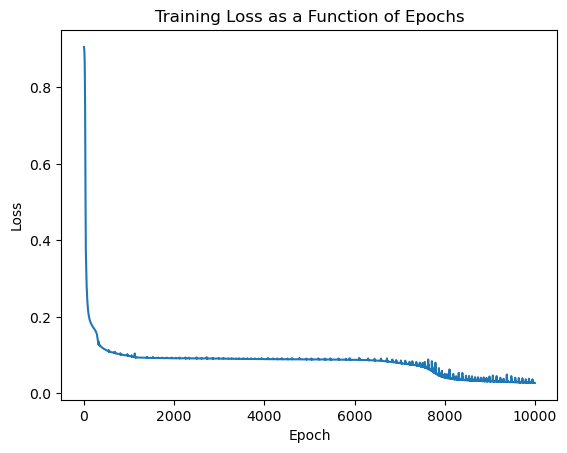

In [38]:
# Plot the loss values
plt.plot(pinn.loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title('Training Loss as a Function of Epochs')
plt.show()

<div style="background-color: #ccffcc; padding: 10px;">

## Prediction with Test Data

Now we've trained our Physics-Informed Neural Network (PINN) for the Navier-Stokes equations, we can use some test data to see how it performs. We will use a single snapshot of the original dataset to test our model.

1. Test Data Preparation:

* `snap` is an array containing the snapshot index for which predictions are to be made (the index can vary between 0 and 199).
* `x_star`, `y_star`, and `t_star` are the spatial and temporal coordinates of the test data.
* `u_star`, `v_star`, and `p_star` are the true velocity components and pressure at the test data points.

2. Prediction:

The `predict` method of the `pinn` object is called with the test data coordinates to obtain the predicted velocity components (`u_pred`, `v_pred`) and pressure (`p_pred`).

3. Evaluation:

Compute the error between the predicted and true values to evaluate the model's performance.
Visualize the predictions and compare them with the true values.

In [ ]:
# Test Data
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

u_pred, v_pred, p_pred = pinn.predict(torch.tensor(x_star, dtype=torch.float32, requires_grad=True), 
                                      torch.tensor(y_star, dtype=torch.float32, requires_grad=True), 
                                      torch.tensor(t_star, dtype=torch.float32, requires_grad=True))

In [ ]:
lambda_1 = pinn.lambda_1
lambda_2 = pinn.lambda_2

# Error
error_u = np.linalg.norm(u_star-u_pred.detach().numpy(),2)/np.linalg.norm(u_star,2) * 100
error_v = np.linalg.norm(v_star-v_pred.detach().numpy(),2)/np.linalg.norm(v_star,2) * 100
p1 = p_star - p_star.mean()
p2 = p_pred.detach().numpy() - p_pred.detach().numpy().mean()
error_p = np.linalg.norm(p1-p2,2)/np.linalg.norm(p1,2) * 100

error_lambda_1 = np.abs(lambda_1.detach().numpy() - 1.0)*100
error_lambda_2 = np.abs(lambda_2.detach().numpy() - 0.01)/0.01 * 100

print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  
     
# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
NN = 200
x = np.linspace(lb[0], ub[0], NN)
y = np.linspace(lb[1], ub[1], NN)
X, Y = np.meshgrid(x,y)

UU_star = griddata(X_star, u_pred.detach().numpy().flatten(), (X, Y), method='cubic')
VV_star = griddata(X_star, v_pred.detach().numpy().flatten(), (X, Y), method='cubic')
PP_star = griddata(X_star, p_pred.detach().numpy().flatten(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

<div style="background-color: #ccffcc; padding: 10px;">

### Define some plotting tools

`plot_solution` is a helper function that grids the data and plots the velocity field.

`axisEqual3D` is a function to set equal scaling for all three axes (x, y, z) in a 3D plot created using Matplotlib. This ensures that the units are equally scaled across all axes, which is important for accurately representing 3D data.

In [ ]:
def plot_solution(X_star, u_star, index):
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x, y)

    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')

    plt.figure(index)
    plt.pcolor(X, Y, U_star, cmap='jet')
    plt.colorbar()
    plt.show()

# Axis equalizer function remains unchanged
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [ ]:
######################################################################
######## Plot vorticity of periodic steady state  ####################
######################################################################   
 
# Load Data
data_vort = scipy.io.loadmat('Data/cylinder_nektar_t0_vorticity.mat')

x_vort = data_vort['x'] 
y_vort = data_vort['y'] 
w_vort = data_vort['w'] 
modes = np.ndarray.item(data_vort['modes'])
nel = np.ndarray.item(data_vort['nel'])    

xx_vort = np.reshape(x_vort, (modes+1,modes+1,nel), order = 'F')
yy_vort = np.reshape(y_vort, (modes+1,modes+1,nel), order = 'F')
ww_vort = np.reshape(w_vort, (modes+1,modes+1,nel), order = 'F')

box_lb = np.array([1.0, -2.0])
box_ub = np.array([8.0, 2.0])

fig, ax = plt.subplots()
ax.axis('off')
plt.figure(figsize=(16, 8))

####### Row 0: Vorticity ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

for i in range(0, nel):
    h = ax.pcolormesh(xx_vort[:,:,i], yy_vort[:,:,i], ww_vort[:,:,i], cmap='seismic',shading='gouraud',  vmin=-3, vmax=3) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot([box_lb[0],box_lb[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_ub[0],box_ub[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_lb[1],box_lb[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_ub[1],box_ub[1]],'k',linewidth = 1)

ax.set_aspect('equal', 'box')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Vorticity structure of periodic steady state of original dataset', fontsize = 10)
#plt.tight_layout()

In [ ]:
####### Row 1: Training data ##################
########      u(t,x,y)     ###################  
plt.figure(figsize=(20, 8))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')

try:
    x_star=x_star.detach().numpy()
    y_star=y_star.detach().numpy()
except:
    pass


r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]       
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
NN = 200
x = np.linspace(lb[0], ub[0], NN)
y = np.linspace(lb[1], ub[1], NN)
X, Y = np.meshgrid(x,y)
ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

########      v(t,x,y)     ###################        
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')

r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]      
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)
ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)
plt.savefig('figures/PINNS_NS_20000_PDE.png')

In [ ]:
fig, ax = plt.subplots()
plt.figure(figsize=(20, 8))
ax.axis('off')

######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs2[:, 0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
            extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)

########     Exact p(t,x,y)     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
            extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 12)

<div style="background-color: #ccffcc; padding: 10px;">
    
Predicted versus exact instantaneous pressure field at a representative time instant. The pressure can be recovered up to a constant, hence the constant offset between the two plots. This remarkable qualitative agreement highlights the ability of physics-informed neural networks to identify the entire pressure field, despite the fact that no data on the pressure are used during model training. 

**NB** train must be set to approx 10000 to achieve the desired results.
</div>

<hr>

<div style="background-color: #ccffcc; padding: 10px;">

# 2.  Noisy Data
    
We're now going to repeat the previous steps but include some noise in our data to see the effect of that on our results.

</div>

In [ ]:
######################################################################
########################### Noisy Data ###############################
######################################################################
noise = 0.01        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
v_train = v_train+ noise*np.std(v_train)*np.random.randn(v_train.shape[0], v_train.shape[1])  

# Convert training data to tensor format and initialize the model
pinn = PINN(x_train, y_train, t_train, u_train, v_train, layers)

# Train the model
nIter = 20000

<div style="background-color: #D3D3D3; padding: 10px;">

if you wish to load a pre-trained model you will need to copy this code into a cell. Available trained models are on [Hugging Face](https://huggingface.co/CEMAC/NS_PINN/tree/main).

```python
url = 'https://huggingface.co/CEMAC/NS_PINN/resolve/main/pinn_model_noise_niter_20k.pth'
model_path = 'pinn_model_noise_niter_20k.pth'

if not os.path.isfile(model_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(model_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:  # Filter out keep-alive chunks
                    f.write(chunk)
        print("File downloaded successfully.")
    else:
        print(f"Failed to download file. HTTP status code: {response.status_code}")
else:
    print("File already exists.")
pinn.load(model_path)
```

</div>

In [ ]:
# Train the model
pinn.train(nIter)

# Save the model
model_path = 'pinn_model_noise_niter_'+str(nIter)+'.pth'
pinn.save(model_path)

In [ ]:
# Plot the loss values
plt.plot(pinn.loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss as a Function of Epochs')
plt.show()

In [ ]:
# Test PINN at a temporal snapshot
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

u_pred, v_pred, p_pred = pinn.predict(torch.tensor(x_star, dtype=torch.float32, requires_grad=True), 
                                      torch.tensor(y_star, dtype=torch.float32, requires_grad=True), 
                                      torch.tensor(t_star, dtype=torch.float32, requires_grad=True))

In [ ]:
# Estimated parameters
lambda_1_noisy = pinn.lambda_1
lambda_2_noisy = pinn.lambda_2

# Error
error_u = np.linalg.norm(u_star-u_pred.detach().numpy(),2)/np.linalg.norm(u_star,2) * 100
error_v = np.linalg.norm(v_star-v_pred.detach().numpy(),2)/np.linalg.norm(v_star,2) * 100
p1 = p_star - p_star.mean()
p2 = p_pred.detach().numpy() - p_pred.detach().numpy().mean()
error_p = np.linalg.norm(p1-p2,2)/np.linalg.norm(p1,2) * 100

error_lambda_1_noisy = np.abs(lambda_1_noisy.detach().numpy() - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_noisy.detach().numpy() - 0.01)/0.01 * 100

print('Error u: %e' % (error_u))    
print('Error v: %e' % (error_v))    
print('Error p: %e' % (error_p))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
NN = 200
x = np.linspace(lb[0], ub[0], NN)
y = np.linspace(lb[1], ub[1], NN)
X, Y = np.meshgrid(x,y)

UU_star = griddata(X_star, u_pred.detach().numpy().flatten(), (X, Y), method='cubic')
VV_star = griddata(X_star, v_pred.detach().numpy().flatten(), (X, Y), method='cubic')
PP_star = griddata(X_star, p_pred.detach().numpy().flatten(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')

In [ ]:
####### Row 1: Training data ##################
########      u(t,x,y)     ###################  
plt.figure(figsize=(20, 8))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
ax = plt.subplot(gs1[:, 0],  projection='3d')
ax.axis('off')

try:
    x_star=x_star.detach().numpy()
    y_star=y_star.detach().numpy()
except:
    pass

r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]       
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
#nn = 200
x = np.linspace(lb[0], ub[0], NN)
y = np.linspace(lb[1], ub[1], NN)
X, Y = np.meshgrid(x,y)
ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

########      v(t,x,y)     ###################        
ax = plt.subplot(gs1[:, 1],  projection='3d')
ax.axis('off')

r1 = [x_star.min(), x_star.max()]
r2 = [data['t'].min(), data['t'].max()]      
r3 = [y_star.min(), y_star.max()]

for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
        ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

ax.scatter(x_train, t_train, y_train, s = 0.1)
ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)

ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')    
ax.set_xlim3d(r1)
ax.set_ylim3d(r2)
ax.set_zlim3d(r3)
axisEqual3D(ax)

In [ ]:
fig, ax = plt.subplots()
plt.figure(figsize=(20, 8))
ax.axis('off')

######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs2[:, 0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
            extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)

########     Exact p(t,x,y)     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
            extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 12)

<div style="background-color: #ccffcc; padding: 10px;"> 
    
If you have not been able to run enough training iterations, the figures produced after running 20000 iterations can be found below:
    
* [Solution with network trained over 20000 iterations](figures/PINNS_NS_20000_PDE.png)
* [Figure comparing predicted vs exact with network trained over 20000 iterations](figures/PINNS_NS_20000_predict_vs_exact.png)

**Further Work**

Congratulations, you have now trained another physics-informed neural network!

This network contains a number of hyper-parameters that could be tuned to give better results. Various hyper-parameters include:
- number of data training points `N_train`,
- number of `layers` in the network,
- number of neurons per layer,
- optimisation.

It is also possible to use different sampling techniques for training data points. We randomly select $N_u$ data points, but alternative methods could be choosing only boundary points or choosing more points near the $t=0$ boundary.

    
</div>